## "When are Iterative Gaussian Processes Reliably Accurate?"

by Wesley Maddox, Sanyam Kapoor, Andrew Gordon Wilson

*Beyond First-Order Methods in ML Workshop at ICML 2021*: https://sites.google.com/view/optml-icml2021/accepted-papers?authuser=0

Local link: https://wjmaddox.github.io/assets/iterative_gps_optml.pdf

In [1]:
import torch

import time

import sys
sys.path.append("/home/wesley_m/PyTorch-LBFGS/functions")
from LBFGS import FullBatchLBFGS



## Gaussian Process Intro

\begin{align}
f \sim \mathcal{GP}(\mu_\theta, k_\theta(\mathbf{X}, \mathbf{X}))
\end{align}
\begin{align}
y \sim \mathcal{N}(f, \sigma^2 I)
\end{align}

While extremely flexible models, the catch with GPs is that the kernel function induces a matrix of size $n \times n$ that must be inverted for GP prediction and training.

Predictive equations:
\begin{align}
p(f(\mathbf{X}_\star) \mid \mathbf{X}_\star,& \mathcal{D}, \theta) = \mathcal{N}(\mu(\mathbf{X}_\star), \Sigma(\mathbf{X}_\star)), \label{eq:gp_post} \\
\mu(\mathbf{X}_\star) &= K_{\mathbf{X}_\star, \mathbf{X}} \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1} \mathbf{y}~, \nonumber \\
\Sigma(\mathbf{X}_\star) &= K_{\mathbf{X}_\star, \mathbf{X}_\star} - K_{\mathbf{X}_\star, \mathbf{X}} \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1} K_{\mathbf{X}_\star, \mathbf{X}}^\top ~, \nonumber
\end{align}
where $\widehat{K}_{\mathbf{X},\mathbf{X}} = K_{\mathbf{X},\mathbf{X}} + \sigma^2 \mathbf{I}$.


More specifically, this requires solving $n \times n$ systems of equations of the following form: 
<!-- \begin{align}
\LARGE z = {\widehat{K}_{\mathbf{X},\mathbf{X}} v}
\end{align} -->
\begin{align}
\LARGE {\widehat{K}_{\mathbf{X},\mathbf{X}}} z = v
\end{align}
which naively takes $\mathcal{O}(n^3)$, thus limiting GP regression to generally no more than $\mathcal{O}(10,000)$ data points. 

In [2]:
device = torch.device("cuda:2")
dtype = torch.float

## Iterative Gaussian Processes

References for iterative GPs are:

**Conjugate Gradients**
- Cutajar et al, 2016: https://arxiv.org/abs/1602.06693
- Gardner et al, NeurIPS, 2018: https://arxiv.org/abs/1809.11165
- Wang et al, NeurIPS, 2019: https://arxiv.org/abs/1903.08114

**Lanczos Decompositions**
- Pleiss et al, ICML, 2018: https://arxiv.org/abs/1803.06058

In general, Lanczos decompositions approximate the posterior covariance in the following format:

\begin{align}
\Sigma(\mathbf{X}_\star) &= K_{\mathbf{X}_\star, \mathbf{X}_\star} - K_{\mathbf{X}_\star, \mathbf{X}} \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1} K_{\mathbf{X}_\star, \mathbf{X}}^\top \\
&= K_{\mathbf{X}_\star, \mathbf{X}_\star} - K_{\mathbf{X}_\star, \mathbf{X}} LL^\top K_{\mathbf{X}_\star, \mathbf{X}}^\top,
\end{align}
where $LL^\top \approx \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1}.$ The rank $r$ of the Lanczos decomposition tends to determine the performance of the approximation.

Here, we use the sarcos problem from http://www.gaussianprocess.org/gpml/data/ and only consider one output testing out the generality of our findings.


In [3]:
import gpytorch

# from bayesian_benchmarks.data import get_regression_data
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels.keops import MaternKernel
from gpytorch.kernels import ScaleKernel
from gpytorch.priors import GammaPrior
from botorch.models.transforms import Normalize, Standardize

In [4]:
from scipy.io import loadmat

In [5]:
data = loadmat("./sarcos_inv.mat")

In [6]:
data["sarcos_inv"].shape

(44484, 28)

In [7]:
X_train = data["sarcos_inv"][..., :-7]
Y_train = data["sarcos_inv"][..., -1].reshape(-1, 1)

In [8]:
from gpytorch.likelihoods import GaussianLikelihood

In [16]:
model = SingleTaskGP(
    torch.tensor(X_train).contiguous(),
    torch.tensor(Y_train).contiguous(),
    covar_module = ScaleKernel(
        MaternKernel(nu=2.5, lengthscale_prior=GammaPrior(3.0, 6.0)),
        outputscale_prior=GammaPrior(2.0, 5.0),
    ),
    input_transform = Normalize(d=X_train.shape[-1]),
    outcome_transform = Standardize(1),
    likelihood = GaussianLikelihood()
).to(device=device, dtype=dtype)

model.train()
model.likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [17]:
model.train_inputs[0].is_contiguous()

True

In [18]:
from botorch.optim.fit import fit_gpytorch_torch

In [19]:
model.likelihood.noise

tensor([0.6932], device='cuda:2', grad_fn=<AddBackward0>)

In [20]:
mll = ExactMarginalLogLikelihood(model.likelihood, model)
# optimizer = FullBatchLBFGS(model.parameters(), lr = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [21]:
# fit_gpytorch_torch(mll, options = {"maxiter": 500});

In [22]:
high_tol_time = []
for i in range(50):
    start = time.time()
    optimizer.zero_grad()
    with gpytorch.settings.cg_tolerance(0.1):
        loss = -mll(model.likelihood(model(*model.train_inputs)), model.train_targets).sum()
        loss.backward()
        
    optimizer.step()
    end = time.time()
    high_tol_time.append(end - start)
    
    if i % 5 == 0:
        print("Step: ", i, "Loss: ", loss.item())

[pyKeOps] Compiling libKeOpstorch2fc2ebd593 in /home/wesley_m/.cache/pykeops-1.5-cpython-39:
       formula: Grad_WithSavedForward(Sum_Reduction(((((Var(2,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))) + (IntCst(1) + (Var(3,1,2) * Square(Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1))))))))) * Exp((Var(4,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))))) * Var(5,11,1)),0), Var(0,21,0), Var(6,11,0), Var(7,11,0))
       aliases: Var(0,21,0); Var(1,21,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,11,1); Var(6,11,0); Var(7,11,0); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorcha01202ecf4 in /home/wesley_m/.cache/pykeops-1.5-cpython-39:
       formula: Grad_WithSavedForward(Sum_Reduction(((((Var(2,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))) + (IntCst(1) + (Var(3,1,2) * Square(Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1))))))))) * Exp((Var(4,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))))) * Var(5,11,1)),0), Var(1,21,1), Var(6,11,0), Var(7,11,0

/home/wesley_m/gpytorch/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.5217968225479126 which is larger than the tolerance of 0.1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [23]:
model.likelihood.noise

tensor([0.0063], device='cuda:2', grad_fn=<AddBackward0>)

In [24]:
print("Total Time: ", sum(high_tol_time) / 60)

Total Time:  4.5111519455909725


In [25]:
test_data = loadmat("./sarcos_inv_test.mat")
X_test= test_data["sarcos_inv_test"][..., :-7]
Y_test = test_data["sarcos_inv_test"][..., -1].reshape(-1, 1)

In [26]:
with torch.no_grad():
    posterior = model.posterior(
        torch.tensor(X_test, device=device, dtype=dtype)
    )

[pyKeOps] Compiling libKeOpstorch7db2687e99 in /home/wesley_m/.cache/pykeops-1.5-cpython-39:
       formula: Sum_Reduction(((((Var(2,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))) + (IntCst(1) + (Var(3,1,2) * Square(Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1))))))))) * Exp((Var(4,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))))) * Var(5,1,1)),0)
       aliases: Var(0,21,0); Var(1,21,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,1,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch70f8b5486e in /home/wesley_m/.cache/pykeops-1.5-cpython-39:
       formula: Sum_Reduction(((((Var(2,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))) + (IntCst(1) + (Var(3,1,2) * Square(Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1))))))))) * Exp((Var(4,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))))) * Var(5,100,1)),0)
       aliases: Var(0,21,0); Var(1,21,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,100,1); 
       dtype  : float32
... 
Done.


In [27]:
mse = torch.mean((posterior.mean.cpu() - torch.tensor(Y_test))**2)
print(mse)

nll = -torch.distributions.Normal(
    posterior.mean, posterior.variance**0.5
).log_prob(torch.tensor(Y_test, device=device, dtype=dtype)).mean()
print(nll)

tensor(0.0177, dtype=torch.float64)
tensor(0.1601, device='cuda:2', grad_fn=<NegBackward0>)


### Investigating the Predictive Variances

- Kapoor et al, ICML '21 https://arxiv.org/abs/2106.06695
- Sun et al, ICML '21 https://arxiv.org/abs/2106.05992
- Potapczynski et al, ICML, '21 https://arxiv.org/abs/2102.06695

(array([3.074e+03, 8.930e+02, 3.070e+02, 1.160e+02, 3.700e+01, 1.400e+01,
        6.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0.02439433, 0.28254074, 0.54068714, 0.79883355, 1.0569799 ,
        1.3151263 , 1.5732727 , 1.8314191 , 2.0895655 , 2.347712  ,
        2.6058583 ], dtype=float32),
 <BarContainer object of 10 artists>)

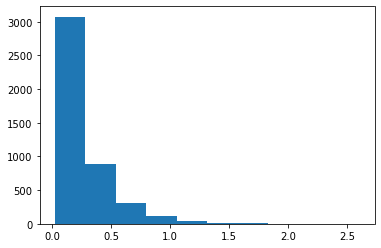

In [28]:
import matplotlib.pyplot as plt

plt.hist(posterior.variance.cpu().detach().numpy())

While the MSE is pretty small, the NLL is much lower than the MSE would natively suggest. Indeed, investigating the NLL, we can immediately spot what's going on: 

\begin{align}
\LARGE \mathrm{NLL}(\sigma^2) := \frac{1}{2}\log \sigma^2 + \frac{1}{2\sigma^2}(\mu - y)^2~,
\end{align}

In [29]:
rank_test = [10, 50, 100, 1000, 5000, 10000]
nll_rank_list = []

for rank in rank_test:
    model.train() # to clear any caches
    with gpytorch.settings.max_root_decomposition_size(rank):
        posterior = model.posterior(
            torch.tensor(X_test, device=device, dtype=dtype)
        )
        nll = torch.distributions.Normal(
            posterior.mean, 
            posterior.variance**0.5
        ).log_prob(
            torch.tensor(Y_test, device=device, dtype=dtype)
        ).mean()
        nll_rank_list.append(nll)

[pyKeOps] Compiling libKeOpstorchdc9f7eb4d4 in /home/wesley_m/.cache/pykeops-1.5-cpython-39:
       formula: Sum_Reduction(((((Var(2,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))) + (IntCst(1) + (Var(3,1,2) * Square(Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1))))))))) * Exp((Var(4,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))))) * Var(5,10,1)),0)
       aliases: Var(0,21,0); Var(1,21,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,10,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorche4fcc557a4 in /home/wesley_m/.cache/pykeops-1.5-cpython-39:
       formula: Sum_Reduction(((((Var(2,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))) + (IntCst(1) + (Var(3,1,2) * Square(Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1))))))))) * Exp((Var(4,1,2) * Sqrt(Sum(Square((Var(0,21,0) - Var(1,21,1)))))))) * Var(5,50,1)),0)
       aliases: Var(0,21,0); Var(1,21,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,50,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling 

/home/wesley_m/gpytorch/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


(-1.0, 3.0)

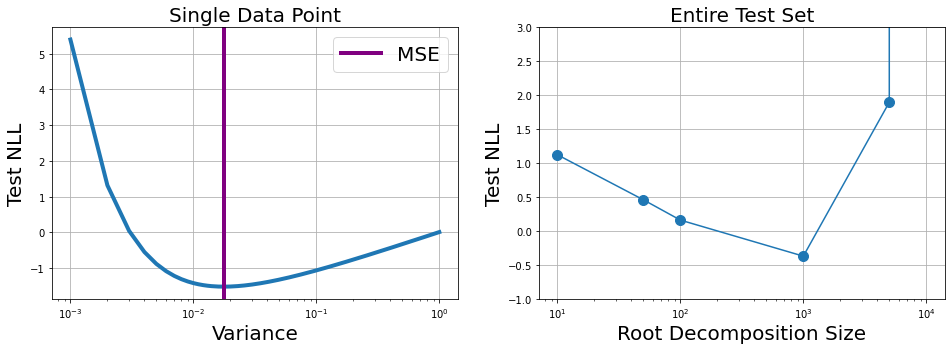

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

var_range = torch.linspace(0.001, 1.0, 1000)
ax[0].plot(
    var_range, 
    0.5 * (var_range.log() + mse.cpu().detach() / var_range), 
    linewidth = 4
)
ax[0].axvline(mse.cpu().detach(), color = "purple", linewidth = 4, label = "MSE")
ax[0].legend(fontsize = 20)
ax[0].semilogx()
ax[0].set_xlabel("Variance", fontsize = 20)
ax[0].set_ylabel("Test NLL", fontsize = 20)
ax[0].grid()

ax[0].set_title("Single Data Point", fontsize = 20)

ax[1].plot(
    rank_test, 
    [-x.detach().cpu() for x in nll_rank_list], 
    marker = ".", 
    markersize = 20
)
ax[1].semilogx()
ax[1].set_xlabel("Root Decomposition Size", fontsize = 20)
ax[1].set_ylabel("Test NLL", fontsize = 20)
ax[1].grid()
ax[1].set_title("Entire Test Set", fontsize = 20)

ax[1].set_ylim((-1, 3))


### Investigating the Predictive Means

Finally, we close by demonstrating the effect of the predictive means using the conjugate gradients tolerance threshold.

In [34]:
from gpytorch.distributions import MultivariateNormal

def mock_predictive_mean(test_X):
    # faked mean cache
    model.input_transform.eval()
    test_X = model.input_transform(test_X)
    train_X = model.input_transform(*model.train_inputs)
    
    model.train()
    prior = MultivariateNormal(model.mean_module(train_X), model.covar_module(train_X))
    train_dist = model.likelihood(prior)
    train_mean, train_train_covar = train_dist.loc, train_dist.lazy_covariance_matrix
    train_labels_offset = (
        model.train_targets - train_mean
    ).unsqueeze(-1)
    
    # compute z = \hat K^{-1} (y - \mu)
    mean_cache = train_train_covar.evaluate_kernel().inv_matmul(
        train_labels_offset
    ).squeeze(-1)
    


    # compute K_{test, train} z
    test_train_covar = model.covar_module(test_X, train_X)
    test_pred_zero_mean = test_train_covar.matmul(mean_cache)
    
    return train_dist.loc[0] * torch.ones_like(
        test_pred_zero_mean
    ) + test_pred_zero_mean

In [35]:
cg_test = [1.0, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
mse_tol_list = []

# we iterate over the set of cg tolerances
for tol in cg_test:
    with gpytorch.settings.cg_tolerance(tol), \
        gpytorch.settings.skip_posterior_variances(True):
        mocked_mean = mock_predictive_mean(
            torch.tensor(X_test, device=device, dtype=dtype)
        )
        mean_untrans = mocked_mean.unsqueeze(-1)
        model.outcome_transform.eval()
        mean_trans, _ = model.outcome_transform.untransform(mean_untrans)
        mse = torch.mean(
            (mean_trans.cpu() - \
             torch.tensor(Y_test)
        )**2).detach()
    mse_tol_list.append(mse)

/home/wesley_m/gpytorch/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.0003581183264032006 which is larger than the tolerance of 0.0001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/wesley_m/gpytorch/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.0003581183264032006 which is larger than the tolerance of 1e-05 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


(0.0, 0.4)

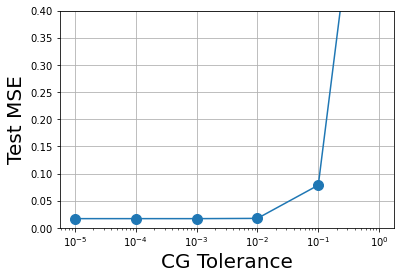

In [41]:
plt.plot(cg_test, mse_tol_list, marker = ".", markersize = 20)
plt.semilogx()

plt.xlabel("CG Tolerance", fontsize = 20)
plt.ylabel("Test MSE", fontsize = 20)
plt.grid()
plt.ylim((0, 0.4))

In [37]:
model.likelihood.noise

tensor([0.0063], device='cuda:2', grad_fn=<AddBackward0>)

/home/wesley_m/gpytorch/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


<ErrorbarContainer object of 3 artists>

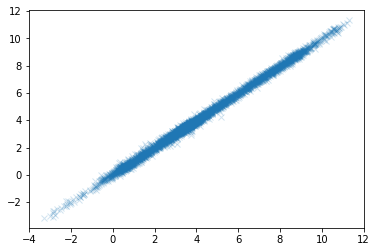

In [38]:
plt.errorbar(Y_test, posterior.mean.cpu().detach().view(-1).numpy(), 
             yerr=posterior.variance.cpu().detach().pow(0.5).view(-1) * 2,
            ls = "none", marker = "x", alpha = 0.2)

In [39]:
posterior.variance.cpu().detach().pow(0.5).view(-1).min()

/home/wesley_m/gpytorch/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


tensor(0.0010)

In [40]:
Y_test.max()

11.27683